In [16]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.datasets import load_wine
import pandas as pd
import matplotlib.pyplot as plt

In [17]:
def quantize(data, n_bits):
    # 2 bits = 4 niveaux (00, 01, 10, 11)
    n_levels = 2**n_bits
    
    # Normaliser les données entre 0 et n_levels-1
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    normalized = (data - min_vals) / (max_vals - min_vals) * (n_levels-1)
    
    # Quantifier en valeurs entières de 0 à n_levels-1
    quantized = np.round(normalized).astype(int)
    quantized = np.clip(quantized, 0, n_levels-1)
    
    return quantized



def non_uniform_quantize(data, n_bits):
    n_levels = 2 ** n_bits
    
    # Calcul des quantiles pour les limites de chaque niveau
    quantiles = np.linspace(0, 1, n_levels + 1)
    thresholds = np.percentile(data, quantiles * 100)
    
    # Fonction de quantification : on affecte à chaque valeur de `data` un niveau
    quantized_data = np.digitize(data, thresholds[1:], right=True)
    
    return quantized_data


def export_data(data, filename):
    df = pd.DataFrame(data)
    df.to_csv(filename, header=False, index=False)
    print(f"Données exportées dans {filename}")

def process_dataset_from_sklearn(dataset_name, n_bits):
    if dataset_name == "iris":
        data = load_iris()
        output_file = f"data/iris_uni_{n_bits}bits.csv"
    elif dataset_name == "wine":
        data = load_wine() 
        output_file = f"data/wine_uni_{n_bits}bits.csv"
    else:
        raise ValueError("Dataset must be 'iris' or 'wine'")
    
    print(f"Dataset : {dataset_name}")
    print(f"Number of samples: {data.data.shape[0]}")
    print(f"Number of features: {data.data.shape[1]}")
    print(f"Number of classes: {len(np.unique(data.target))}")
    print("---")
    
    X = data.data
    X_quantized = quantize(X, n_bits)
    
    # Combine features and target into one array before exporting
    full_data = np.column_stack((X_quantized, data.target))
    export_data(full_data, output_file)


def non_uniform_process_dataset_from_sklearn(dataset_name, n_bits):
    if dataset_name == "iris":
        data = load_iris()
        output_file = f"data/iris_non_uni_{n_bits}bits.csv"
    elif dataset_name == "wine":
        data = load_wine() 
        output_file = f"data/wine_non_uni_{n_bits}bits.csv"
    else:
        raise ValueError("Dataset must be 'iris' or 'wine'")
    
    print(f"Dataset : {dataset_name}")
    print(f"Number of samples: {data.data.shape[0]}")
    print(f"Number of features: {data.data.shape[1]}")
    print(f"Number of classes: {len(np.unique(data.target))}")
    print("---")
    
    X = data.data
    X_quantized = non_uniform_quantize(X, n_bits)

    # print(X_quantized)
    # print(X_quantized.shape)
    
    # Combine features and target into one array before exporting
    full_data = np.column_stack((X_quantized, data.target))
    export_data(full_data, output_file)




# Friedman-diaconis


In [18]:
def friedman_diaconis_quantize(data, n_bits):
    n_levels = 2 ** n_bits
    n_samples = len(data)
    
    # Calculer la largeur des bins selon Friedman-Diaconis
    q75, q25 = np.percentile(data, [75, 25], axis=0)
    iqr = q75 - q25
    bin_width = 2 * iqr * (n_samples ** (-1/3))
    
    # Créer les seuils pour chaque feature
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    
    # Ajuster le nombre de bins pour respecter n_levels
    n_bins = np.minimum(n_levels, np.ceil((max_vals - min_vals) / bin_width).astype(int))
    
    # Créer les seuils pour chaque feature
    thresholds = [np.linspace(min_vals[i], max_vals[i], n_bins[i]) 
                 for i in range(data.shape[1])]
    
    # Quantifier chaque feature
    quantized = np.zeros_like(data, dtype=int)
    for i in range(data.shape[1]):
        quantized[:, i] = np.digitize(data[:, i], thresholds[i][1:], right=True)
        # Normaliser pour avoir des valeurs entre 0 et n_levels-1
        quantized[:, i] = np.minimum(quantized[:, i], n_levels-1)
    
    return quantized


def fd_process_dataset_from_sklearn(dataset_name, n_bits):
    if dataset_name == "iris":
        data = load_iris()
        output_file = f"data/iris_fd_{n_bits}bits.csv"
    elif dataset_name == "wine":
        data = load_wine() 
        output_file = f"data/wine_fd_{n_bits}bits.csv"
    else:
        raise ValueError("Dataset must be 'iris' or 'wine'")
    
    print(f"Dataset : {dataset_name}")
    print(f"Number of samples: {data.data.shape[0]}")
    print(f"Number of features: {data.data.shape[1]}")
    print(f"Number of classes: {len(np.unique(data.target))}")
    print("---")
    
    X = data.data
    X_quantized = friedman_diaconis_quantize(X, n_bits)
    
    full_data = np.column_stack((X_quantized, data.target))
    export_data(full_data, output_file)

In [19]:
process_dataset_from_sklearn("iris", 5)

Dataset : iris
Number of samples: 150
Number of features: 4
Number of classes: 3
---
Données exportées dans data/iris_uni_5bits.csv


In [20]:

non_uniform_process_dataset_from_sklearn("iris", 5)

Dataset : iris
Number of samples: 150
Number of features: 4
Number of classes: 3
---
Données exportées dans data/iris_non_uni_5bits.csv


In [21]:
fd_process_dataset_from_sklearn("iris", 5)

Dataset : iris
Number of samples: 150
Number of features: 4
Number of classes: 3
---
Données exportées dans data/iris_fd_5bits.csv


In [22]:
import pandas as pd
def calculate_column_mean(csv_file, column_index):
    """
    Calculate mean of a specific column from a CSV file
    
    Args:
        csv_file (str): Path to the CSV file
        column_index (int): Index of the column to calculate mean for
        
    Returns:
        float: Mean value of the specified column
    """
    # Read CSV into DataFrame without headers
    df = pd.read_csv(csv_file, header=None)
    
    # Calculate mean of specified column
    column_mean = df[column_index].mean()
    
    return column_mean




In [23]:
# acc_wine_mean_4 = calculate_column_mean("logs/wine_4bits_4_64.csv", 0)
# print(f"Mean accuracy wine depth 4 : {acc_wine_mean_4}")
# acc_wine_mean_3 = calculate_column_mean("logs/wine_4bits_3_64.csv", 0)
# print(f"Mean accuracy wine depth 3 : {acc_wine_mean_3}")
# acc_wine_mean_2 = calculate_column_mean("logs/wine_4bits_2_64.csv", 0)
# print(f"Mean accuracy wine depth 2 : {acc_wine_mean_2}")
# # acc_wine_mean_1 = calculate_column_mean("logs/wine_4bits_1_64.csv", 0)
# # print(f"Mean accuracy wine depth 1 : {acc_wine_mean_1}")
# time_wine_mean_4 = calculate_column_mean("logs/wine_4bits_4_64.csv", 1)
# print(f"Mean time wine depth 4: {time_wine_mean_4}")
# time_wine_mean_3 = calculate_column_mean("logs/wine_4bits_3_64.csv", 1)
# print(f"Mean time wine depth 3 : {time_wine_mean_3}")
# time_wine_mean_2 = calculate_column_mean("logs/wine_4bits_2_64.csv", 1)
# print(f"Mean time wine depth 2 : {time_wine_mean_2}")
# # acc_wine_mean_1 = calculate_column_mean("logs/wine_4bits_1_64.csv", 0)
# # print(f"Mean accuracy wine depth 1 : {acc_wine_mean_1}")

In [24]:
acc_iris_mean_4 = calculate_column_mean("logs/iris_4bits_4_64.csv", 0)
print(f"Mean accuracy iris depth 4 : {acc_iris_mean_4}")
acc_iris_mean_3 = calculate_column_mean("logs/iris_4bits_3_64.csv", 0)
print(f"Mean accuracy iris depth 3 : {acc_iris_mean_3}")
# acc_iris_mean_2 = calculate_column_mean("logs/iris_4bits_2_64.csv", 0)
# print(f"Mean accuracy iris depth 2 : {acc_iris_mean_2}")
# acc_iris_mean_1 = calculate_column_mean("logs/iris_4bits_1_64.csv", 0)
# print(f"Mean accuracy iris depth 1 : {acc_iris_mean_1}")
time_iris_mean_4 = calculate_column_mean("logs/iris_4bits_4_64.csv", 1)
print(f"Mean time iris depth 4: {time_iris_mean_4}")
time_iris_mean_3 = calculate_column_mean("logs/iris_4bits_3_64.csv", 1)
print(f"Mean time iris depth 3 : {time_iris_mean_3}")
# time_iris_mean_2 = calculate_column_mean("logs/iris_4bits_2_64.csv", 1)
# print(f"Mean time iris depth 2 : {time_iris_mean_2}")
# acc_iris_mean_1 = calculate_column_mean("logs/iris_4bits_1_64.csv", 0)
# print(f"Mean accuracy iris depth 1 : {acc_iris_mean_1}")

FileNotFoundError: [Errno 2] No such file or directory: 'logs/iris_4bits_4_64.csv'

/var/folders/zf/mm8hyjbs5kdg2gxhblkfwn0c0000gn/T/ipykernel_43403/582839107.py:23: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "^-" (-> linestyle='-'). The keyword argument will take precedence.
  ax1.plot(depth[2:], accuracy_private_wine[2:], '^-', label="Accuracy PrivateDTs", color='black', linestyle="--")
/var/folders/zf/mm8hyjbs5kdg2gxhblkfwn0c0000gn/T/ipykernel_43403/582839107.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "^-" (-> linestyle='-'). The keyword argument will take precedence.
  ax2.plot(depth[2:], accuracy_private_iris[2:], '^-', label="Accuracy PrivateDTs", color='black', linestyle="--")


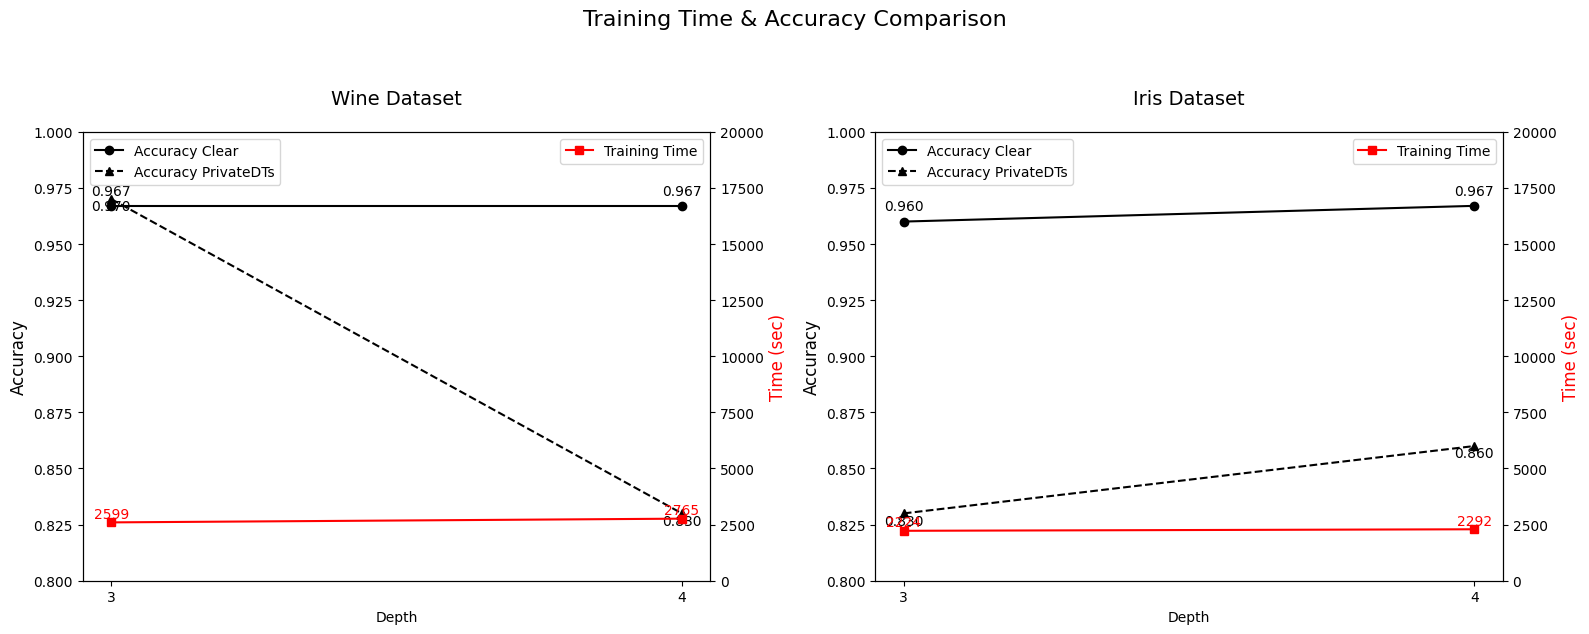

In [127]:
import matplotlib.pyplot as plt

# Données pour reproduire le graphique
depth = [1, 2, 3, 4]  # Profondeur
accuracy_clear_wine = [None, None, 0.967, 0.967]
accuracy_private_wine = [None, None, 0.97, 0.83]
training_time_wine = [None, None, 2599, 2765]

accuracy_clear_iris = [None, None, 0.960, 0.967]
accuracy_private_iris = [None, None, 0.83, 0.86]
training_time_iris = [None, None, 2224, 2292]

# Créer deux sous-graphiques
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Premier graphique pour Wine
ax1_twin = ax1.twinx()
ax1.set_xlabel("Depth")
ax1.set_ylabel("Accuracy", fontsize=12)
ax1.set_ylim(0.8, 1.0)
ax1.set_xticks(depth)
ax1.plot(depth[2:], accuracy_clear_wine[2:], 'o-', label="Accuracy Clear", color='black')
ax1.plot(depth[2:], accuracy_private_wine[2:], '^-', label="Accuracy PrivateDTs", color='black', linestyle="--")

# Ajouter les valeurs sur les points pour Wine
for i in range(2, len(depth)):
    ax1.text(depth[i], accuracy_clear_wine[i] + 0.005, f"{accuracy_clear_wine[i]:.3f}", ha='center')
    ax1.text(depth[i], accuracy_private_wine[i] - 0.005, f"{accuracy_private_wine[i]:.3f}", ha='center')

ax1_twin.set_ylabel("Time (sec)", fontsize=12, color="red")
ax1_twin.set_ylim(0, 20000)
ax1_twin.plot(depth[2:], training_time_wine[2:], 's-', color='red', label="Training Time")

# Ajouter les valeurs pour les temps (Wine)
for i in range(2, len(depth)):
    ax1_twin.text(depth[i], training_time_wine[i] + 200, f"{training_time_wine[i]}", color="red", ha='center')

# Deuxième graphique pour Iris
ax2_twin = ax2.twinx()
ax2.set_xlabel("Depth")
ax2.set_ylabel("Accuracy", fontsize=12)
ax2.set_ylim(0.8, 1.0)
ax2.set_xticks(depth)
ax2.plot(depth[2:], accuracy_clear_iris[2:], 'o-', label="Accuracy Clear", color='black')
ax2.plot(depth[2:], accuracy_private_iris[2:], '^-', label="Accuracy PrivateDTs", color='black', linestyle="--")

# Ajouter les valeurs sur les points pour Iris
for i in range(2, len(depth)):
    ax2.text(depth[i], accuracy_clear_iris[i] + 0.005, f"{accuracy_clear_iris[i]:.3f}", ha='center')
    ax2.text(depth[i], accuracy_private_iris[i] - 0.005, f"{accuracy_private_iris[i]:.3f}", ha='center')

ax2_twin.set_ylabel("Time (sec)", fontsize=12, color="red")
ax2_twin.set_ylim(0, 20000)
ax2_twin.plot(depth[2:], training_time_iris[2:], 's-', color='red', label="Training Time")

# Ajouter les valeurs pour les temps (Iris)
for i in range(2, len(depth)):
    ax2_twin.text(depth[i], training_time_iris[i] + 200, f"{training_time_iris[i]}", color="red", ha='center')

# Titres et légendes
ax1.set_title("Wine Dataset", fontsize=14, pad=20)
ax2.set_title("Iris Dataset", fontsize=14, pad=20)

ax1.legend(loc="upper left")
ax1_twin.legend(loc="upper right")
ax2.legend(loc="upper left")
ax2_twin.legend(loc="upper right")

fig.suptitle("Training Time & Accuracy Comparison", fontsize=16, y=1.05)
plt.tight_layout()


plt.show()

# Quantization analysis

/var/folders/zf/mm8hyjbs5kdg2gxhblkfwn0c0000gn/T/ipykernel_82640/169747667.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
/var/folders/zf/mm8hyjbs5kdg2gxhblkfwn0c0000gn/T/ipykernel_82640/169747667.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
/var/folders/zf/mm8hyjbs5kdg2gxhblkfwn0c0000gn/T/ipykernel_82640/169747667.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


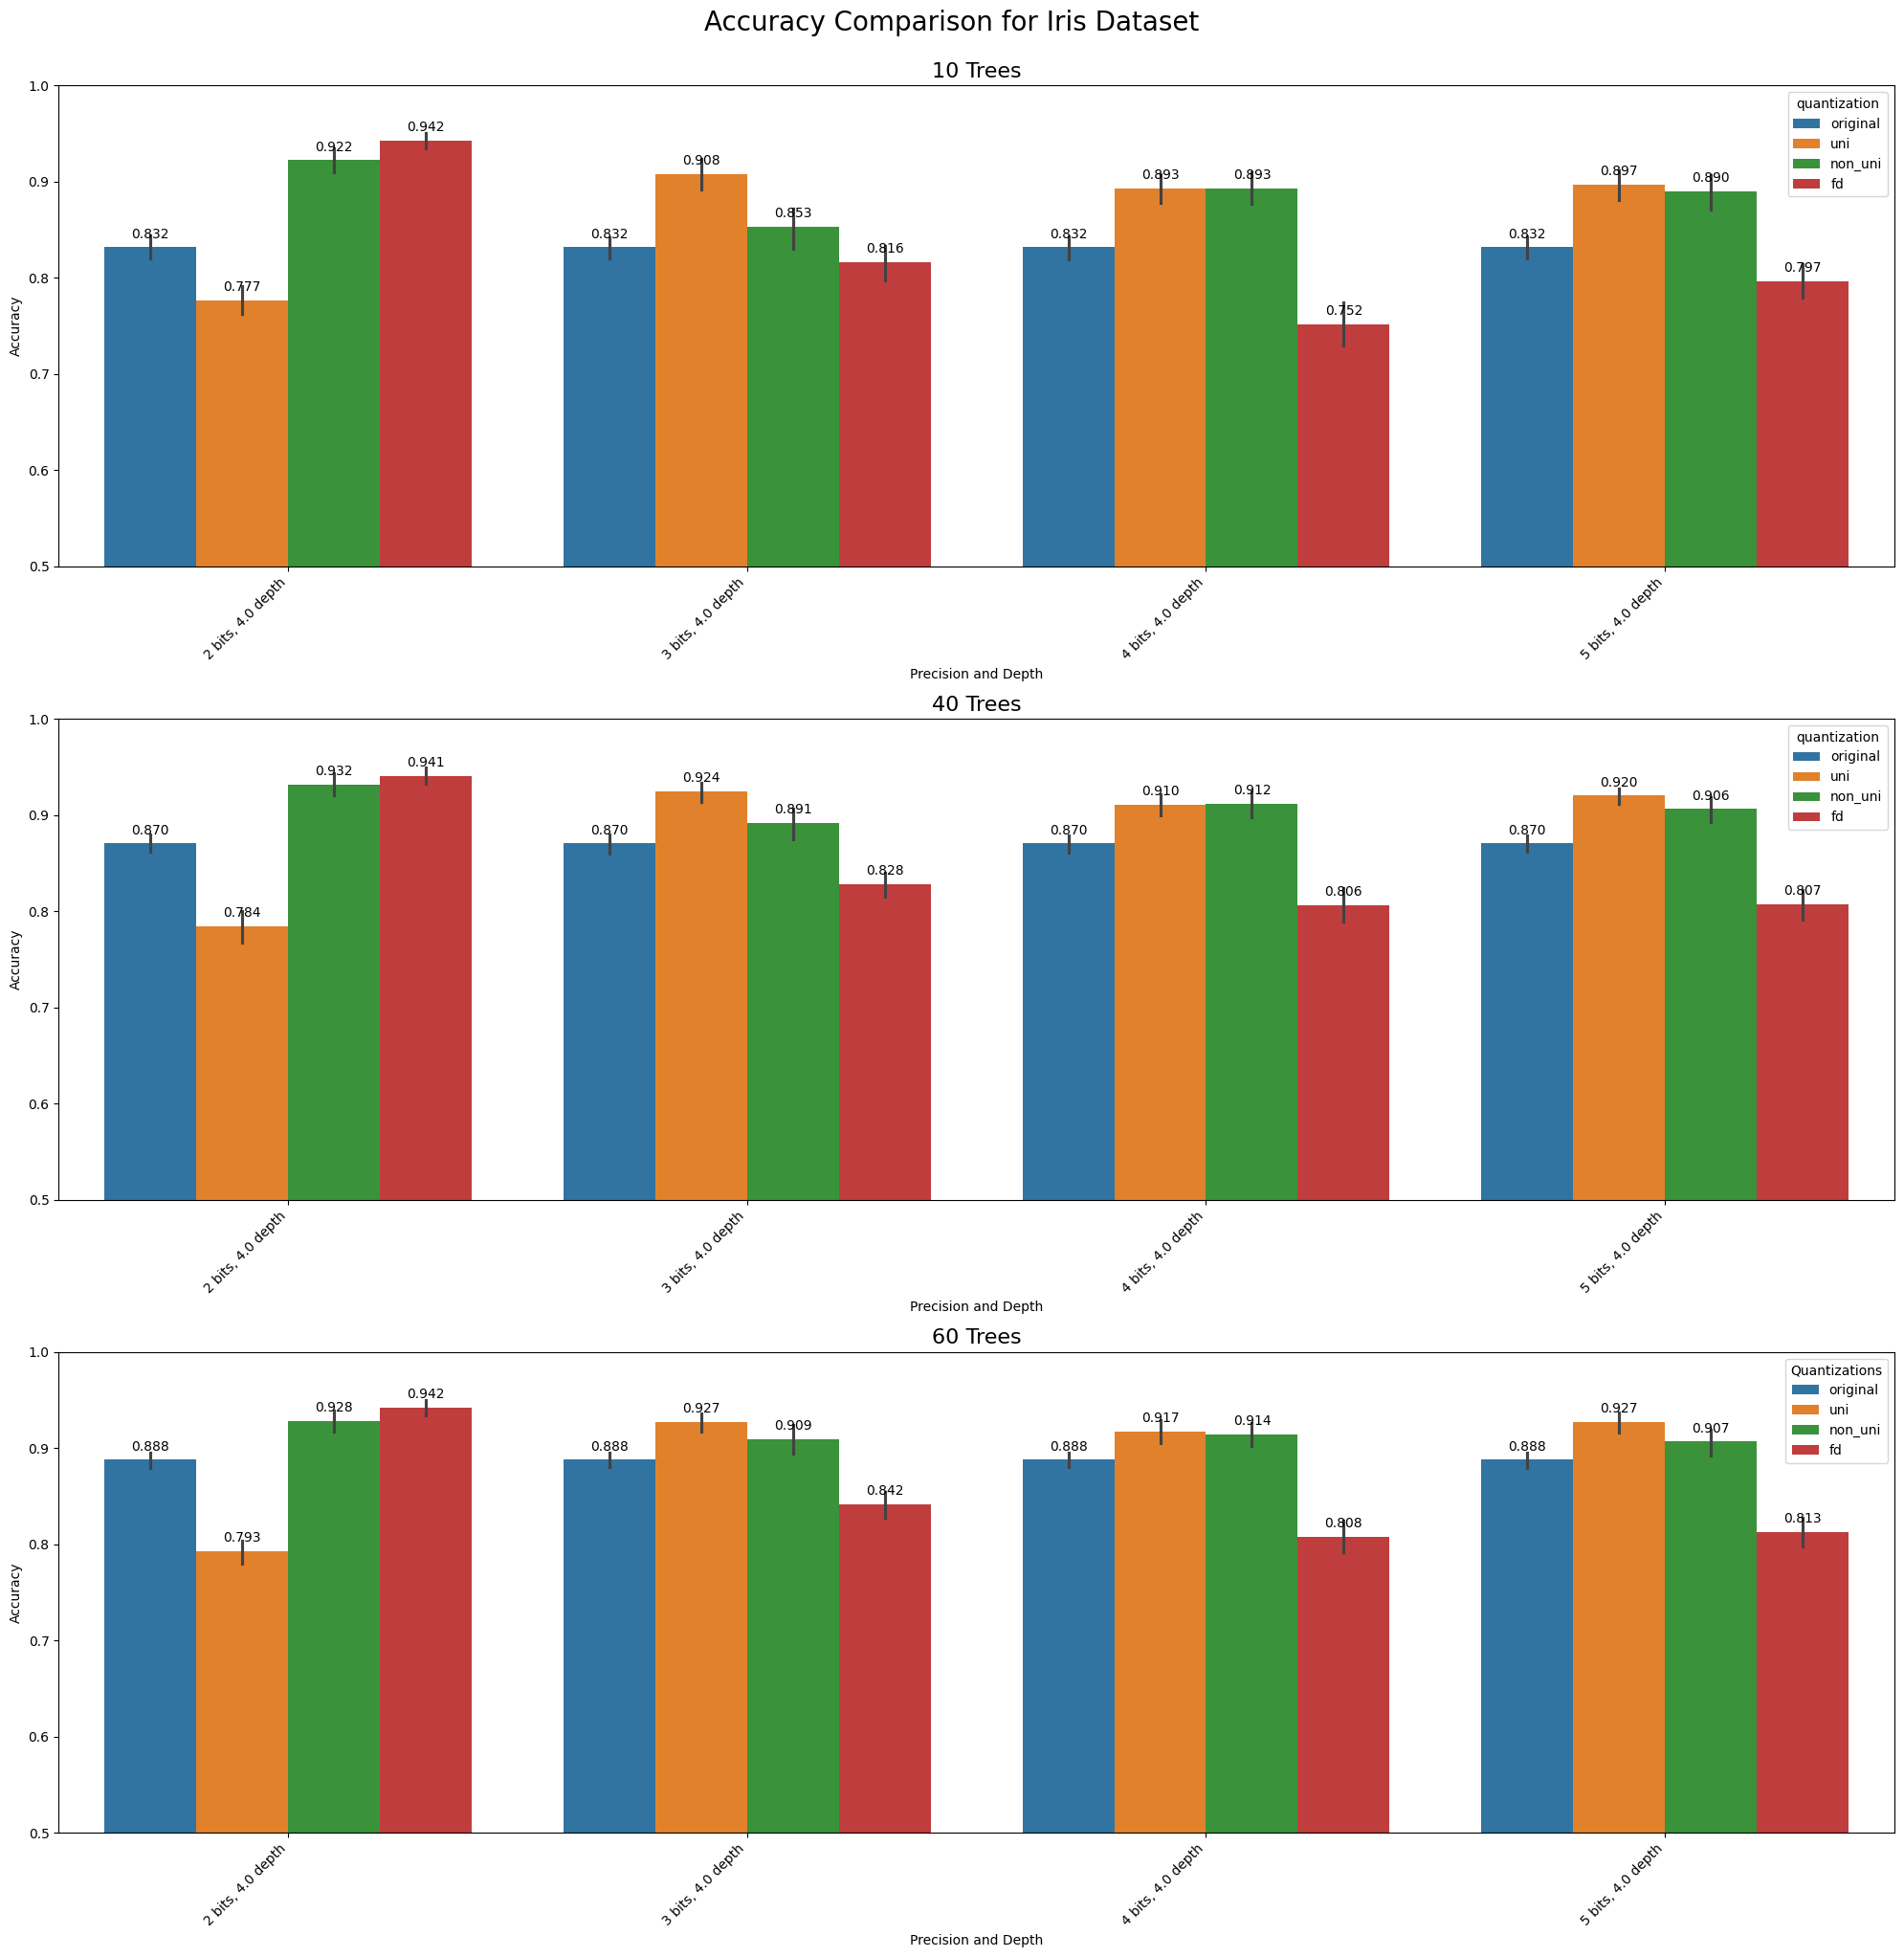

In [25]:
import pandas as pd
import seaborn as sns

dataset_name = "iris"
precisions = [2, 3, 4, 5]
num_forests = [10, 40, 60]
quantizations = ["original","uni", "non_uni", "fd"]
depths = [4]

data = pd.DataFrame(columns=["precision", "num_forests", "quantizations", "depths"])

for n_bits in precisions:
    for n_forests in num_forests:
        for quantization in quantizations:
            for depth in depths:
                if quantization == "original":
                    filename = f"logs/{dataset_name}_{depth}d_{n_forests}m_clear.csv"
                else:
                    filename = f"logs/{dataset_name}_{quantization}_{n_bits}bits_{depth}d_{n_forests}m_clear.csv"
                result = pd.read_csv(filename, header=None, names=["accuracy", "training_time", "inference_time"])
                result["precision"] = n_bits
                result["num_forests"] = n_forests
                result["quantization"] = quantization
                result["depth"] = depth
                data = pd.concat([data, result])

data["precision_depth"] = data["precision"].astype(str) + " bits, " + data["depth"].astype(str) + " depth"

fig = plt.figure(figsize=(20, 20))
# plot for each num_forests

for i, n_forests in enumerate(num_forests):
    ax = fig.add_subplot(3, 1, i+1)
    sns.barplot(x="precision_depth", y="accuracy", hue="quantization", data=data[data["num_forests"] == n_forests], ax=ax) 
    ax.set_ylim(0.5, 1)# Rotate x-axis labels for better readability
    # add a subtitle for each plot
    ax.set_title(f"{n_forests} Trees", fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_xlabel("Precision and Depth")
    ax.set_ylabel("Accuracy")
    # add the text on top of each bar
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.3f}", (p.get_x() + p.get_width() / 2., p.get_height()), ha="center", va="center", xytext=(0, 10), textcoords='offset points')

plt.tight_layout()

# add a title for the whole plot
fig.suptitle(f"Accuracy Comparison for {dataset_name.capitalize()} Dataset", fontsize=20, y=1.02)
plt.legend(title="Quantizations")
# plt.tight_layout()
plt.show()




